# Revision Analysis

Analyzing:
1. Time dependency of editing by looking at pegRNAs with neutral LFC vs. selected pegRNAs.
2. Closer analysis of hotspot mutations.

In [47]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [2]:
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [3]:
LFC_min = -.5
LFC_max = .5

#start with non-nutlin
a = list(mageck_dict['D16'][(mageck_dict['D16']['LFC']>=LFC_min) & (mageck_dict['D16']['LFC']<=LFC_max)]['peg_id'])
b = list(mageck_dict['D25'][(mageck_dict['D25']['LFC']>=LFC_min) & (mageck_dict['D25']['LFC']<=LFC_max)]['peg_id'])
c = list(mageck_dict['D34'][(mageck_dict['D34']['LFC']>=LFC_min) & (mageck_dict['D34']['LFC']<=LFC_max)]['peg_id'])


#and nutlin
a1 = list(mageck_dict['D16-NUT'][(mageck_dict['D16-NUT']['LFC']>=LFC_min) & (mageck_dict['D16-NUT']['LFC']<=LFC_max)]['peg_id'])
b1= list(mageck_dict['D25-NUT'][(mageck_dict['D25-NUT']['LFC']>=LFC_min) & (mageck_dict['D25-NUT']['LFC']<=LFC_max)]['peg_id'])
c1 = list(mageck_dict['D34-NUT'][(mageck_dict['D34-NUT']['LFC']>=LFC_min) & (mageck_dict['D34-NUT']['LFC']<=LFC_max)]['peg_id'])

untreated_set = list(set(a) & set(b) & set(c))

nutlin_set = list(set(a1) & set(b1) & set(c1))

In [4]:

kk = ['D4','D16', 'D25', 'D34']

counts = []
cp = []
peg_id = []

for k in kk:
    a = cp_dict2[k]
    a = a[a['peg_id'].isin(untreated_set)].sort_values(by='peg_id')

    counts.append(list(a['Reads_aligned_all_amplicons']))
    cp.append(list(a['corr_perc']))
    peg_id.append(list(a['peg_id']))

df = pd.DataFrame(dict(zip(['peg_id'], [peg_id[0]])))

for i, val in enumerate(kk):
    df[f'counts_{val}'] = counts[i]
    df[f'corr_perc_{val}'] = cp[i]

In [5]:
counts_threshold = 100

df_mincounts = df[(df['counts_D4']>=counts_threshold) & (df['counts_D16']>=counts_threshold) & (df['counts_D25']>=counts_threshold) &(df['counts_D34']>=counts_threshold)]

df_mincounts


,peg_id,counts_D4,corr_perc_D4,counts_D16,corr_perc_D16,counts_D25,corr_perc_D25,counts_D34,corr_perc_D34
4,peg_10053,101,0.000000,688,0.000000,875,0.000000,977,0.000000
8,peg_10081,895,0.000000,1771,0.000000,1828,0.328228,1980,0.202020
9,peg_10085,908,0.220264,2004,0.000000,1791,0.223339,1809,0.165837
10,peg_10087,718,0.000000,1451,0.000000,1593,0.000000,1443,0.069300
11,peg_10088,13381,0.112099,35061,3.134537,25571,5.940323,34890,7.526512
...,...,...,...,...,...,...,...,...,...
3919,peg_9809,5551,0.018015,11055,0.768883,10847,0.875818,12866,0.893829
3920,peg_9813,7384,0.000000,12622,0.316907,11257,0.142134,12436,0.353812
3928,peg_9892,199,0.000000,606,1.815182,1117,1.253357,813,1.230012
3929,peg_9922,1550,0.193548,3864,2.251553,3400,2.382353,2833,5.894811


In [6]:
#limit it to pegRNAs with observable editing at EVERY timepoint

min_edit=1

observed_editing = df_mincounts[(df_mincounts['corr_perc_D4']>=min_edit) & (df_mincounts['corr_perc_D16']>=min_edit) &(df_mincounts['corr_perc_D25']>=min_edit) & (df_mincounts['corr_perc_D34']>=min_edit)]
observed_editing

,peg_id,counts_D4,corr_perc_D4,counts_D16,corr_perc_D16,counts_D25,corr_perc_D25,counts_D34,corr_perc_D34
12,peg_10113,3370,2.284866,8209,12.973566,7585,21.397495,6213,27.184935
13,peg_10115,3355,3.576751,10092,20.055489,9579,32.320702,7286,40.776832
48,peg_10387,20577,1.948778,41175,5.748634,30048,9.681177,41306,13.799448
49,peg_10388,14097,1.681209,27707,10.762623,21935,14.802827,33779,26.658575
51,peg_10390,33071,3.217320,65053,12.912548,46758,19.466188,72156,27.024780
...,...,...,...,...,...,...,...,...,...
3862,peg_9463,14643,1.761934,29875,6.346444,23036,9.615385,27761,13.328050
3866,peg_9467,12569,1.074071,23508,6.227667,18827,11.865937,26653,15.274078
3869,peg_9471,59906,6.004407,128708,24.658918,79482,36.398178,103250,46.601453
3897,peg_9612,4074,31.173294,7744,62.241736,6036,67.842942,10365,75.677762


In [7]:
w = np.array(observed_editing['corr_perc_D4'])
x = np.array(observed_editing['corr_perc_D16'])
y = np.array(observed_editing['corr_perc_D25'])
z = np.array(observed_editing['corr_perc_D34'])

stacked = np.vstack((w, x,y,z))

stacked.T

array([[ 2.28486647, 12.9735656 , 21.39749506, 27.18493481],
       [ 3.57675112, 20.0554895 , 32.32070153, 40.77683228],
       [ 1.94877776,  5.74863388,  9.68117678, 13.79944802],
       ...,
       [ 6.0044069 , 24.65891786, 36.3981782 , 46.60145278],
       [31.17329406, 62.24173554, 67.84294235, 75.6777617 ],
       [ 1.2793177 ,  4.97835498,  6.85483871,  8.04362645]])

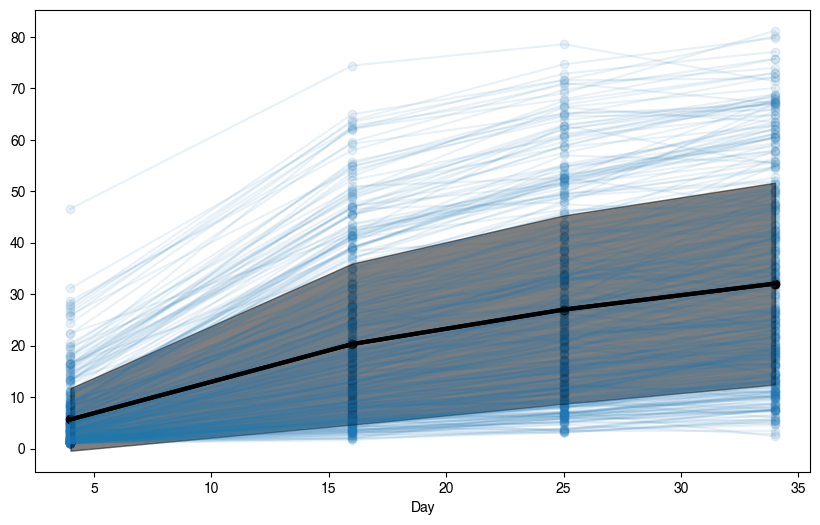

In [8]:
x = [4, 16,25,34]
fig, ax = plt.subplots(figsize=(10,6))
for i in stacked.T:
    plt.plot(x, i, color='tab:blue', alpha=0.1)
    plt.scatter(x, i, color='tab:blue', alpha=0.1)

plt.xlabel('Day')

plt.plot(x, np.average(stacked, axis=1), color='black', alpha=1, linewidth=3)
plt.scatter(x, np.average(stacked, axis=1), color='black')

y1 = np.average(stacked, axis=1) - np.std(stacked, axis=1)
y2 = np.average(stacked, axis=1) + np.std(stacked, axis=1)
plt.plot(x, np.average(stacked, axis=1), color='black', alpha=1, linewidth=3)

ax.fill_between(x, y1, y2, alpha=.5, color='black')

In [208]:
np.std(stacked, axis=1)

array([ 6.07342026, 15.64455196, 18.29673989, 19.60103462])

I think it would make sense to normalize everything (so look at fold increase...)

In [209]:
normed = [stacked[0]/stacked[0], stacked[1]/stacked[0], stacked[2]/stacked[0], stacked[3]/stacked[0]]
stacked_norm = np.array(normed).T

In [210]:
min(stacked[0])

1.0012743491716731

Text(0.5, 0, 'Day')

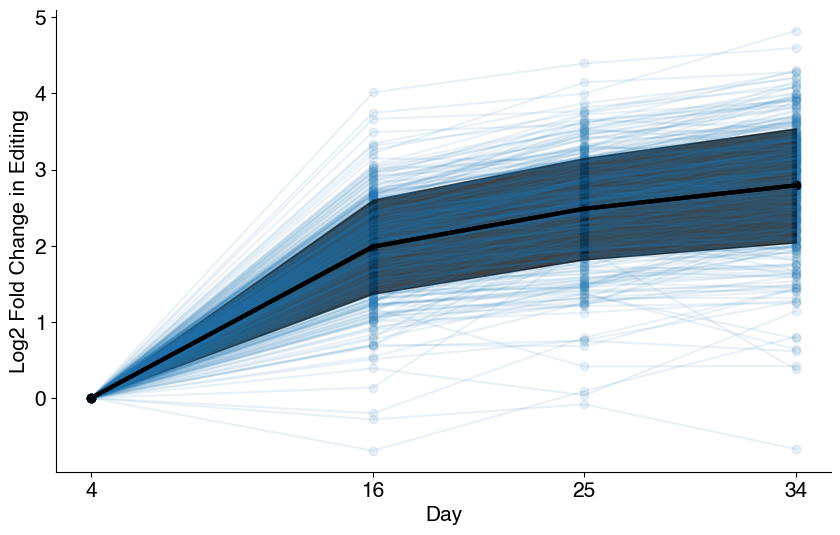

In [9]:
x = [4, 16,25,34]
fig, ax = plt.subplots(figsize=(10,6))

normed = [stacked[0]/stacked[0], stacked[1]/stacked[0], stacked[2]/stacked[0], stacked[3]/stacked[0]]
stacked_norm = np.array(normed).T

stacked_norm = np.log2(stacked_norm)

for i in stacked_norm:
    plt.plot(x, i, color='tab:blue', alpha=0.1)
    plt.scatter(x, i, color='tab:blue', alpha=0.1)

plt.xlabel('Day')

plt.plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
plt.scatter(x, np.average(stacked_norm, axis=0), color='black')

y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
plt.plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

ax.fill_between(x, y1, y2, alpha=.5, color='black')


ax.fill_between(x, y1, y2, alpha=.5, color='black')
ax.set_xticks([4, 16,25,34]);
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Log2 Fold Change in Editing', fontsize=15)
ax.set_xlabel('Day', fontsize=15)

Text(0.5, 0, 'Day')

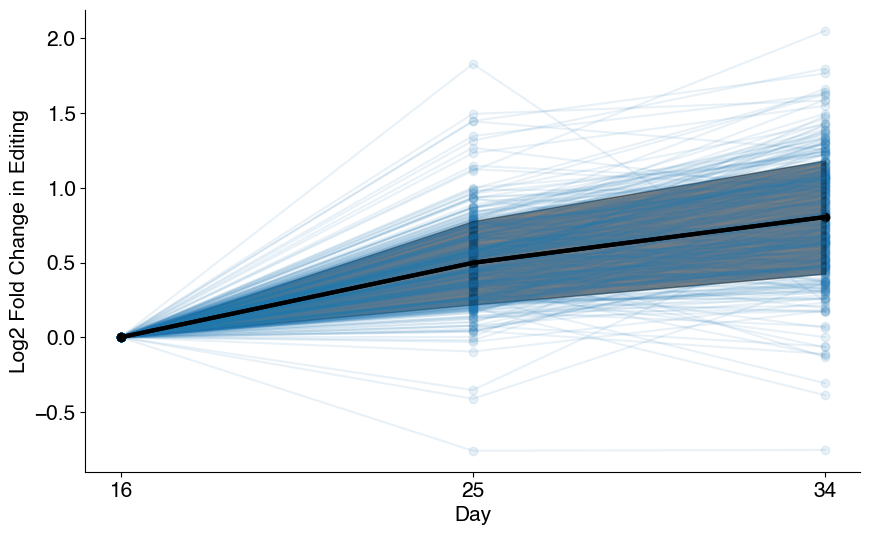

In [218]:
#this time norm to D16

normed = [stacked[1]/stacked[1], stacked[2]/stacked[1], stacked[3]/stacked[1]]
stacked_norm = np.array(normed).T

#log2 transform
stacked_norm = np.log2(stacked_norm)

x = [16,25,34]
fig, ax = plt.subplots(figsize=(10,6))
for i in stacked_norm:
    plt.plot(x, i, color='tab:blue', alpha=0.1)
    plt.scatter(x, i, color='tab:blue', alpha=0.1)



plt.plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
plt.scatter(x, np.average(stacked_norm, axis=0), color='black')

y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
plt.plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

ax.fill_between(x, y1, y2, alpha=.5, color='black')
ax.set_xticks([16,25,34]);
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Log2 Fold Change in Editing', fontsize=15)
ax.set_xlabel('Day', fontsize=15)


In [152]:
np.average(stacked_norm, axis=0)

array([1.        , 1.54620413, 1.98392597])

# Now generating comparisons between selected and unselected

For the above, try looking at various counts thresholds, minimum correct editing %'s AND compare LFC>x vs. unselected pegRNAs!!!

Show most of the editing is complete by Day 16 (also correlations in supplement show this as well)...See continued editing, but should be self-controlled.

In [10]:
#start with D4
d4 = cp_dict2['D4'][['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']]
d4 = d4.rename(columns = {'Reads_aligned_all_amplicons':f'counts_D4', 'corr_perc':f'corr_perc_D4'})


#untreated samples
untreated = ['D16', 'D25', 'D34']
nutlin = ['D16-NUT', 'D25-NUT', 'D34-NUT']

untreated_merged = []
for sample in untreated:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    untreated_merged.append(merge1)

#nutlin samples
nutlin_merged = []
for sample in nutlin:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    nutlin_merged.append(merge1)

#untreated samples
m1 = pd.merge(d4, untreated_merged[0], on='peg_id', how='left')
m2 = pd.merge(m1, untreated_merged[1], on='peg_id', how='left')
untreated_merge_df = pd.merge(m2, untreated_merged[2], on='peg_id', how='left')

#nutlin samples
n1 = pd.merge(d4, nutlin_merged[0], on='peg_id', how='left')
n2 = pd.merge(n1, nutlin_merged[1], on='peg_id', how='left')
nutlin_merge_df = pd.merge(n2, nutlin_merged[2], on='peg_id', how='left')

untreated_merge_df

,peg_id,counts_D4,corr_perc_D4,LFC_D16,counts_D16,corr_perc_D16,LFC_D25,counts_D25,corr_perc_D25,LFC_D34,counts_D34,corr_perc_D34
0,peg_0,0,0.000000,-0.48530,0.0,0.000000,-0.58779,3.0,0.000000,-0.87533,0.0,0.000000
1,peg_1,0,0.000000,-0.68626,9.0,0.000000,-1.38300,42.0,0.000000,-3.01750,21.0,0.000000
2,peg_2,3188,1.066499,-1.38420,3043.0,1.117318,-1.52450,2212.0,2.667269,-1.46470,2449.0,3.225806
3,peg_3,6253,0.879578,-1.33380,6132.0,5.088063,-1.77960,3975.0,7.899371,-1.59000,4412.0,11.060743
4,peg_4,4301,0.720763,-1.37690,3375.0,1.185185,-1.89530,1904.0,1.943277,-2.18690,1636.0,1.405868
...,...,...,...,...,...,...,...,...,...,...,...,...
28214,peg_28669,2966,0.000000,0.64570,12079.0,0.057952,1.15600,14279.0,0.035016,1.12840,14836.0,0.121327
28215,peg_28670,154,0.000000,0.13216,2126.0,0.000000,0.56255,3123.0,0.032020,0.69144,2576.0,0.000000
28216,peg_28671,875,0.000000,1.30330,4599.0,0.000000,2.05920,6799.0,0.014708,1.93920,6318.0,0.000000
28217,peg_28672,759,0.131752,1.44470,4281.0,0.140154,2.25150,7069.0,0.141463,1.96630,6208.0,0.032216


In [11]:
#now applying the counts and minimum editing filtration...
counts_threshold = 100
min_edit = 1 #minimum 1% editing at all timepoints

#counts thresholding
untreated_merge_df = untreated_merge_df[(untreated_merge_df['counts_D4']>=counts_threshold) & (untreated_merge_df['counts_D16']>=counts_threshold) & (untreated_merge_df['counts_D25']>=counts_threshold) &(untreated_merge_df['counts_D34']>=counts_threshold)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['counts_D4']>=counts_threshold) & (nutlin_merge_df['counts_D16-NUT']>=counts_threshold) &(nutlin_merge_df['counts_D25-NUT']>=counts_threshold) &(nutlin_merge_df['counts_D34-NUT']>=counts_threshold)]

#filtering for only active pegRNAs...
untreated_merge_df = untreated_merge_df[(untreated_merge_df['corr_perc_D4']>=min_edit) & (untreated_merge_df['corr_perc_D16']>=min_edit) &(untreated_merge_df['corr_perc_D25']>=min_edit) &(untreated_merge_df['corr_perc_D34']>=min_edit)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['corr_perc_D4']>=min_edit) & (nutlin_merge_df['corr_perc_D16-NUT']>=min_edit) &(nutlin_merge_df['corr_perc_D25-NUT']>=min_edit) &(nutlin_merge_df['corr_perc_D34-NUT']>=min_edit)]
nutlin_merge_df

,peg_id,counts_D4,corr_perc_D4,LFC_D16-NUT,counts_D16-NUT,corr_perc_D16-NUT,LFC_D25-NUT,counts_D25-NUT,corr_perc_D25-NUT,LFC_D34-NUT,counts_D34-NUT,corr_perc_D34-NUT
2,peg_2,3188,1.066499,-1.227300,1786.0,11.590146,-0.051958,1960.0,14.489796,-1.08790,1455.0,18.487973
30,peg_30,131,2.290076,1.845700,2305.0,2.603037,2.741200,2883.0,1.248699,2.39890,4026.0,1.564829
35,peg_35,4104,1.145224,0.103560,3803.0,3.129109,0.448850,3387.0,5.668733,-0.92993,1919.0,8.181344
36,peg_36,3951,1.392053,0.292020,3011.0,16.937894,0.724140,3352.0,19.093079,-0.36588,2099.0,16.102906
39,peg_39,116,2.586207,3.255900,2156.0,2.782931,3.937300,1707.0,1.230228,3.61750,2418.0,1.240695
...,...,...,...,...,...,...,...,...,...,...,...,...
28053,peg_28508,1094,1.279707,1.483100,2054.0,9.931840,1.546300,981.0,17.023445,2.67040,3396.0,21.171967
28078,peg_28533,20332,1.534527,-0.341540,12464.0,10.101091,0.083954,8897.0,14.960099,-0.38650,8313.0,19.752195
28079,peg_28534,9460,1.892178,0.017285,7372.0,8.355941,-0.067590,3923.0,14.198318,-0.19385,5703.0,18.814659
28083,peg_28538,12108,1.164519,0.085806,9294.0,7.553260,0.615510,7350.0,9.945578,-0.27837,7494.0,13.757673


In [23]:
#start with untreated
LFC_low = -1
LFC_high = 1

mid_untreat = untreated_merge_df[(untreated_merge_df['LFC_D34']<=LFC_high) & (untreated_merge_df['LFC_D34']>=LFC_low)]
high_untreat = untreated_merge_df[(untreated_merge_df['LFC_D34']>LFC_high)]
low_untreat = untreated_merge_df[(untreated_merge_df['LFC_D34']<LFC_low)]

untreated = ['D4', 'D16', 'D25', 'D34']
nutlin = ['D4', 'D16-NUT', 'D25-NUT', 'D34-NUT']


low = [np.array(low_untreat[f'corr_perc_{i}']) for i in untreated]
mid = [np.array(mid_untreat[f'corr_perc_{i}']) for i in untreated]
high = [np.array(high_untreat[f'corr_perc_{i}']) for i in untreated]
low_stacked = np.vstack((low[0], low[1], low[2], low[3]))
mid_stacked = np.vstack((mid[0], mid[1], mid[2], mid[3]))
high_stacked = np.vstack((high[0], high[1], high[2], high[3]))


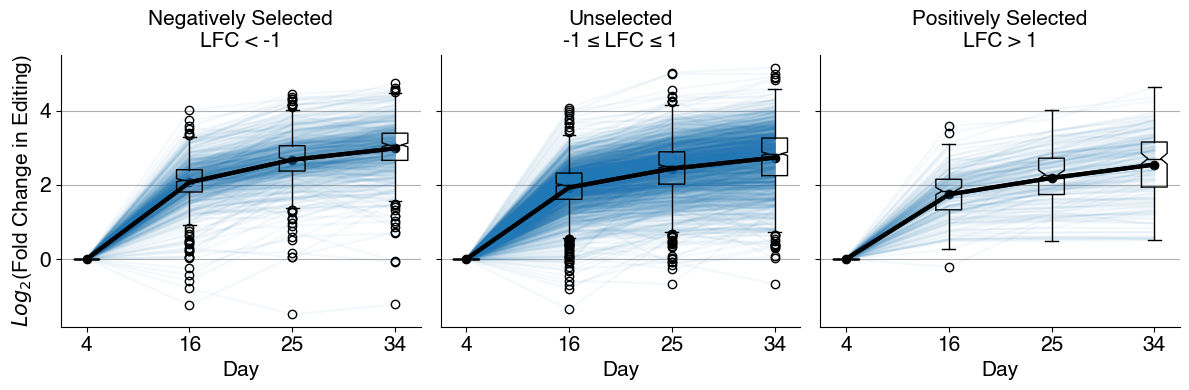

In [28]:
x_ticklabels = [4, 16,25,34]
x = [0,2,4,6]
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

titles = [f'Negatively Selected\nLFC < {LFC_low}', f'Unselected\n{LFC_low} ≤ LFC ≤ {LFC_high}', f'Positively Selected\nLFC > {LFC_high}']

for i, stacked in enumerate([low_stacked, mid_stacked, high_stacked]):
    normed = [stacked[0]/stacked[0], stacked[1]/stacked[0], stacked[2]/stacked[0], stacked[3]/stacked[0]]
    stacked_norm = np.array(normed).T

    stacked_norm = np.log2(stacked_norm)

    for ii in stacked_norm:
        ax[i].plot(x, ii, color='tab:blue', alpha=0.05)
        #ax[i].scatter(x, ii, color='tab:blue', alpha=0.05)

    normed = [np.log2(i) for i in normed]

    medianprops = dict(color='black')
    ax[i].boxplot(normed, positions=x, notch=True, medianprops=medianprops);

    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
    ax[i].scatter(x, np.average(stacked_norm, axis=0), color='black')

    y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
    y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='black')

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='black')

    ax[i].set_xticks(x);
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_ylabel('$Log_{2}$(Fold Change in Editing)', fontsize=15)
    ax[i].set_xlabel('Day', fontsize=15)
    ax[i].set_title(titles[i], fontsize=15)
    ax[i].grid(axis='y')
    ax[i].set_xticklabels(x_ticklabels)


fig.tight_layout()


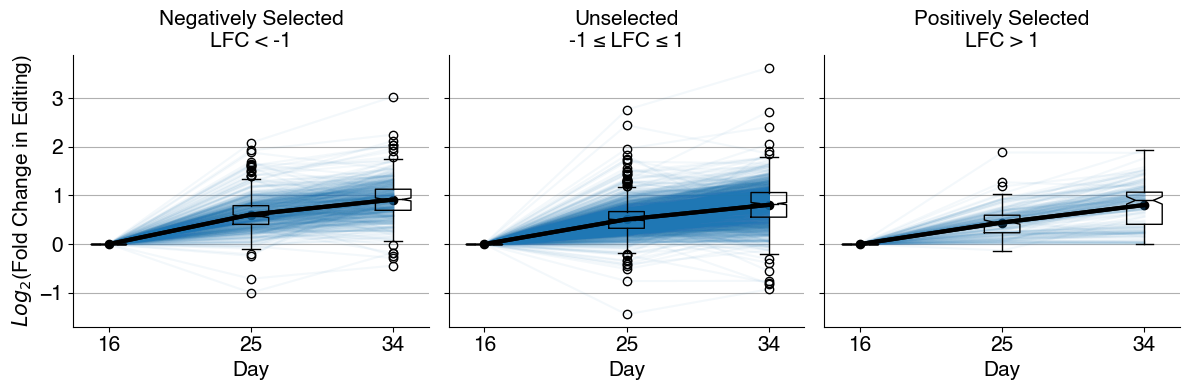

In [29]:
x = [0,2,4]
x_ticklabels = [16,25,34]
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

titles = [f'Negatively Selected\nLFC < {LFC_low}', f'Unselected\n{LFC_low} ≤ LFC ≤ {LFC_high}', f'Positively Selected\nLFC > {LFC_high}']

for i, stacked in enumerate([low_stacked, mid_stacked, high_stacked]):
    normed = [stacked[1]/stacked[1], stacked[2]/stacked[1], stacked[3]/stacked[1]]
    stacked_norm = np.array(normed).T

    stacked_norm = np.log2(stacked_norm)

    for ii in stacked_norm:
        ax[i].plot(x, ii, color='tab:blue', alpha=0.05)
        #ax[i].scatter(x, ii, color='tab:blue', alpha=0.1)

    normed = [np.log2(i) for i in normed]
    medianprops = dict(color='black')
    ax[i].boxplot(normed, positions=x, notch=True, medianprops=medianprops);

    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
    ax[i].scatter(x, np.average(stacked_norm, axis=0), color='black')

    y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
    y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='tab:blue')

    ax[i].set_xticks(x);
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_ylabel('$Log_{2}$(Fold Change in Editing)', fontsize=15)
    ax[i].set_xlabel('Day', fontsize=15)
    ax[i].set_title(titles[i], fontsize=15)
    ax[i].grid(axis='y')
    ax[i].set_xticklabels(x_ticklabels)


fig.tight_layout()

In [32]:
#Need to do the same for nutlin-treated
LFC_low = -1
LFC_high = 1

mid_nut = nutlin_merge_df[(nutlin_merge_df['LFC_D34-NUT']<=LFC_high) & (nutlin_merge_df['LFC_D34-NUT']>=LFC_low)]
high_nut = nutlin_merge_df[(nutlin_merge_df['LFC_D34-NUT']>LFC_high)]
low_nut = nutlin_merge_df[(nutlin_merge_df['LFC_D34-NUT']<LFC_low)]

untreated = ['D4', 'D16', 'D25', 'D34']
nutlin = ['D4', 'D16-NUT', 'D25-NUT', 'D34-NUT']


low = [np.array(low_nut[f'corr_perc_{i}']) for i in nutlin]
mid = [np.array(mid_nut[f'corr_perc_{i}']) for i in nutlin]
high = [np.array(high_nut[f'corr_perc_{i}']) for i in nutlin]
low_stacked = np.vstack((low[0], low[1], low[2], low[3]))
mid_stacked = np.vstack((mid[0], mid[1], mid[2], mid[3]))
high_stacked = np.vstack((high[0], high[1], high[2], high[3]))


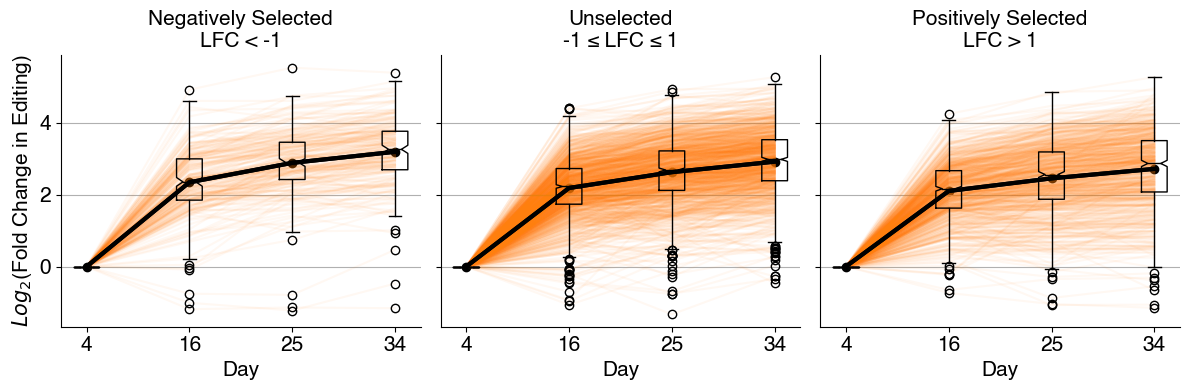

In [34]:
x_ticklabels = [4, 16,25,34]
x = [0,2,4,6]
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

titles = [f'Negatively Selected\nLFC < {LFC_low}', f'Unselected\n{LFC_low} ≤ LFC ≤ {LFC_high}', f'Positively Selected\nLFC > {LFC_high}']

for i, stacked in enumerate([low_stacked, mid_stacked, high_stacked]):
    normed = [stacked[0]/stacked[0], stacked[1]/stacked[0], stacked[2]/stacked[0], stacked[3]/stacked[0]]
    stacked_norm = np.array(normed).T

    stacked_norm = np.log2(stacked_norm)

    for ii in stacked_norm:
        ax[i].plot(x, ii, color='tab:orange', alpha=0.05)
        #ax[i].scatter(x, ii, color='tab:blue', alpha=0.05)

    normed = [np.log2(i) for i in normed]

    medianprops = dict(color='black')
    ax[i].boxplot(normed, positions=x, notch=True, medianprops=medianprops);

    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
    ax[i].scatter(x, np.average(stacked_norm, axis=0), color='black')

    y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
    y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='black')

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='black')

    ax[i].set_xticks(x);
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_ylabel('$Log_{2}$(Fold Change in Editing)', fontsize=15)
    ax[i].set_xlabel('Day', fontsize=15)
    ax[i].set_title(titles[i], fontsize=15)
    ax[i].grid(axis='y')
    ax[i].set_xticklabels(x_ticklabels)


fig.tight_layout()

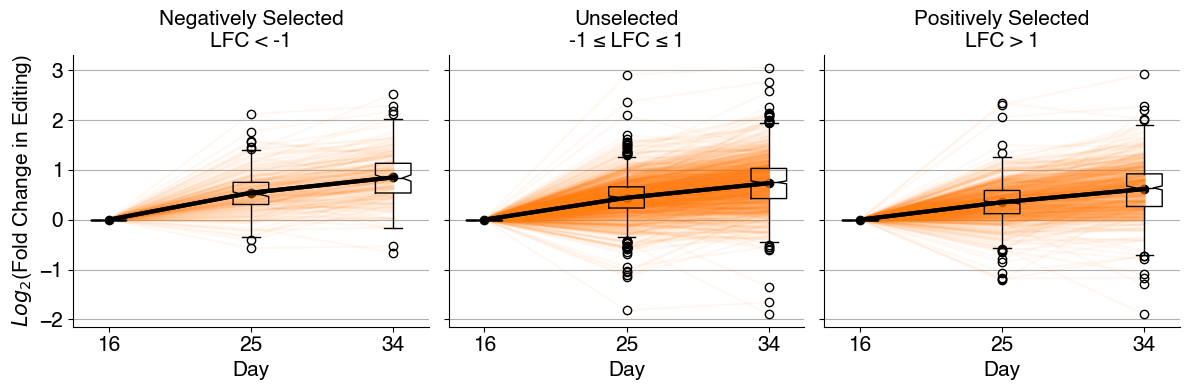

In [35]:
x = [0,2,4]
x_ticklabels = [16,25,34]
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

titles = [f'Negatively Selected\nLFC < {LFC_low}', f'Unselected\n{LFC_low} ≤ LFC ≤ {LFC_high}', f'Positively Selected\nLFC > {LFC_high}']

for i, stacked in enumerate([low_stacked, mid_stacked, high_stacked]):
    normed = [stacked[1]/stacked[1], stacked[2]/stacked[1], stacked[3]/stacked[1]]
    stacked_norm = np.array(normed).T

    stacked_norm = np.log2(stacked_norm)

    for ii in stacked_norm:
        ax[i].plot(x, ii, color='tab:orange', alpha=0.05)
        #ax[i].scatter(x, ii, color='tab:blue', alpha=0.1)

    normed = [np.log2(i) for i in normed]
    medianprops = dict(color='black')
    ax[i].boxplot(normed, positions=x, notch=True, medianprops=medianprops);

    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)
    ax[i].scatter(x, np.average(stacked_norm, axis=0), color='black')

    y1 = np.average(stacked_norm, axis=0) - np.std(stacked_norm, axis=0)
    y2 = np.average(stacked_norm, axis=0) + np.std(stacked_norm, axis=0)
    ax[i].plot(x, np.average(stacked_norm, axis=0), color='black', alpha=1, linewidth=3)

    #ax[i].fill_between(x, y1, y2, alpha=.5, color='tab:blue')

    ax[i].set_xticks(x);
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_ylabel('$Log_{2}$(Fold Change in Editing)', fontsize=15)
    ax[i].set_xlabel('Day', fontsize=15)
    ax[i].set_title(titles[i], fontsize=15)
    ax[i].grid(axis='y')
    ax[i].set_xticklabels(x_ticklabels)


fig.tight_layout()

# Hotspot analysis

In [75]:
vars_only = p53_filtered.drop_duplicates(subset='HGVSp')
top20 = vars_only.sort_values(by='num_occurences', ascending=False)[0:20]

In [175]:
top20['HGVSp']

0        R175H
30       R248Q
54       R273C
84       R273H
114      R248W
139      R282W
163    R213Ter
175      Y220C
205      G245S
234    R196Ter
252    R342Ter
279    R306Ter
309      E285K
334      M237I
343      V157F
373      S241F
394      Y163C
406    Q192Ter
436      H179R
466      R273L
Name: HGVSp, dtype: object

In [37]:
s = 'D34'
counts_threshold=50

cd = cp_dict2[s]
cd = cd[cd['Reads_aligned_all_amplicons']>=counts_threshold]


cs1 = []
hotspot_pegs = []
for i in top20['HGVSp']:

    p = list(p53_filtered[p53_filtered['HGVSp']==i]['peg_id'])
    for ii in p:
        hotspot_pegs.append(ii)
    cs = list(cd[cd['peg_id'].isin(p)]['corr_perc'])
    cs1.append(cs)

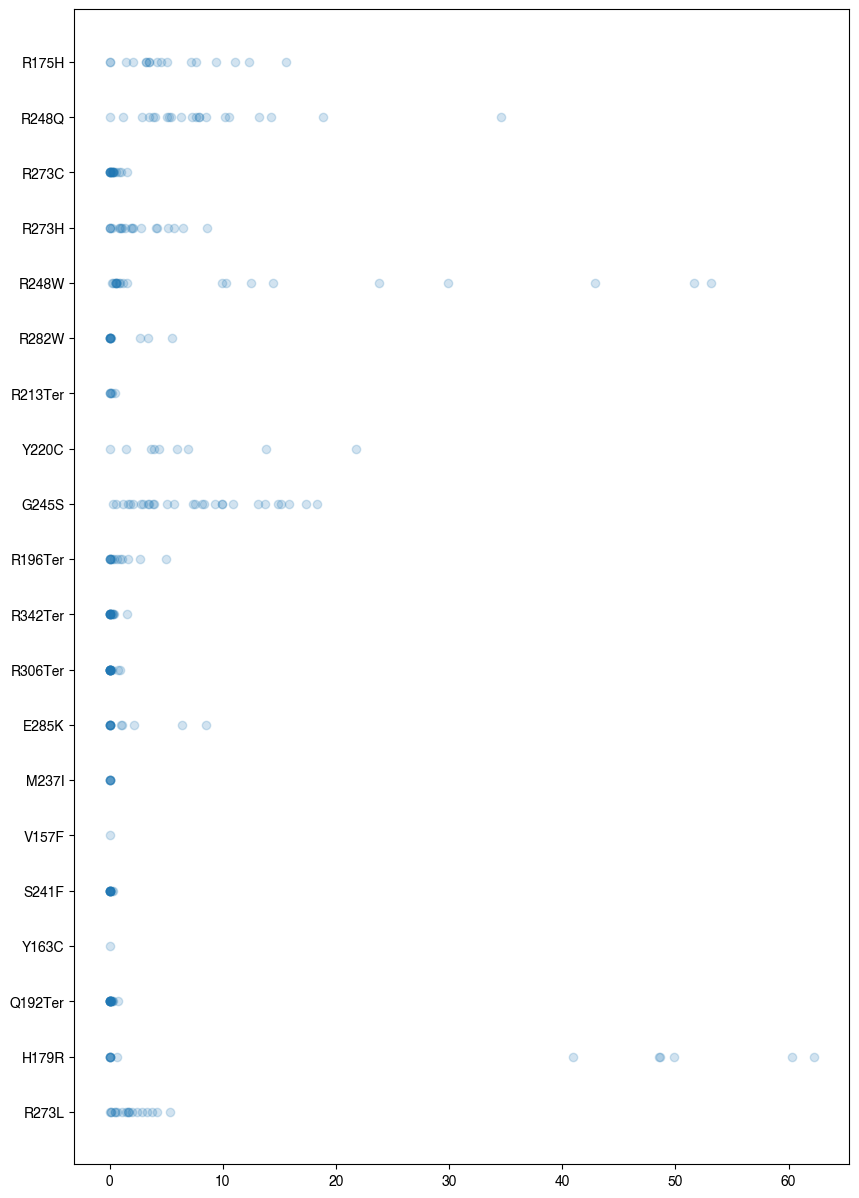

In [38]:
fig, ax = plt.subplots(figsize=(10,15))
for i, val in enumerate(top20['HGVSp']):
    
    plt.scatter( cs1[i], [-i]*len(cs1[i]), color='tab:blue', alpha=.2)

ax.set_yticks(-np.array(list(range(20))));
ax.set_yticklabels(top20['HGVSp']);

In [136]:
#start with D4
d4 = cp_dict2['D4'][['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']]
d4 = d4.rename(columns = {'Reads_aligned_all_amplicons':f'counts_D4', 'corr_perc':f'corr_perc_D4'})


#untreated samples
untreated = ['D16', 'D25', 'D34']
nutlin = ['D16-NUT', 'D25-NUT', 'D34-NUT']

untreated_merged = []
for sample in untreated:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    untreated_merged.append(merge1)

#nutlin samples
nutlin_merged = []
for sample in nutlin:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    nutlin_merged.append(merge1)

#untreated samples
m1 = pd.merge(d4, untreated_merged[0], on='peg_id', how='left')
m2 = pd.merge(m1, untreated_merged[1], on='peg_id', how='left')
untreated_merge_df = pd.merge(m2, untreated_merged[2], on='peg_id', how='left')

#nutlin samples
n1 = pd.merge(d4, nutlin_merged[0], on='peg_id', how='left')
n2 = pd.merge(n1, nutlin_merged[1], on='peg_id', how='left')
nutlin_merge_df = pd.merge(n2, nutlin_merged[2], on='peg_id', how='left')

#----------FILTRATION---------------
#now applying the counts and minimum editing filtration...
counts_threshold = 50
min_edit = 0 #minimum 1% editing at all timepoints

#counts thresholding
untreated_merge_df = untreated_merge_df[(untreated_merge_df['counts_D34']>=counts_threshold)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['counts_D34-NUT']>=counts_threshold)]

#filtering for only active pegRNAs...
untreated_merge_df = untreated_merge_df[(untreated_merge_df['corr_perc_D34']>=min_edit)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['corr_perc_D34-NUT']>=min_edit)]

#------ANNOTATION------
#annotate the hotspots (based on the above list)

untreated_merge_df.loc[untreated_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=True
untreated_merge_df.loc[~untreated_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=False
nutlin_merge_df.loc[nutlin_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=True
nutlin_merge_df.loc[~nutlin_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=False
nutlin_merge_df

,peg_id,counts_D4,corr_perc_D4,LFC_D16-NUT,counts_D16-NUT,corr_perc_D16-NUT,LFC_D25-NUT,counts_D25-NUT,corr_perc_D25-NUT,LFC_D34-NUT,counts_D34-NUT,corr_perc_D34-NUT,hotspot
2,peg_2,3188,1.066499,-1.22730,1786.0,11.590146,-0.051958,1960.0,14.489796,-1.08790,1455.0,18.487973,True
3,peg_3,6253,0.879578,-0.23616,3690.0,7.127371,1.446100,2970.0,11.144781,0.10645,2203.0,13.436223,True
4,peg_4,4301,0.720763,-0.87591,1945.0,0.359897,0.028506,1903.0,0.472937,-1.50950,810.0,1.234568,True
5,peg_5,9971,0.792298,-1.34900,4457.0,11.330491,-0.227230,5254.0,14.921964,-1.39250,3927.0,19.455055,True
6,peg_6,4846,0.557161,-1.07040,1900.0,9.789474,-0.107860,1967.0,12.099644,-1.75830,1013.0,18.460020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28214,peg_28669,2966,0.000000,0.97691,5660.0,0.053004,0.588620,2546.0,0.078555,1.23980,6068.0,0.098879,False
28215,peg_28670,154,0.000000,-0.63935,428.0,0.000000,-1.045200,178.0,0.000000,0.53286,1547.0,0.000000,False
28216,peg_28671,875,0.000000,1.70560,1918.0,0.364964,1.177900,725.0,0.137931,1.76490,2689.0,0.111566,False
28217,peg_28672,759,0.131752,1.38790,1888.0,0.000000,0.803540,633.0,0.000000,1.91780,2307.0,0.000000,False


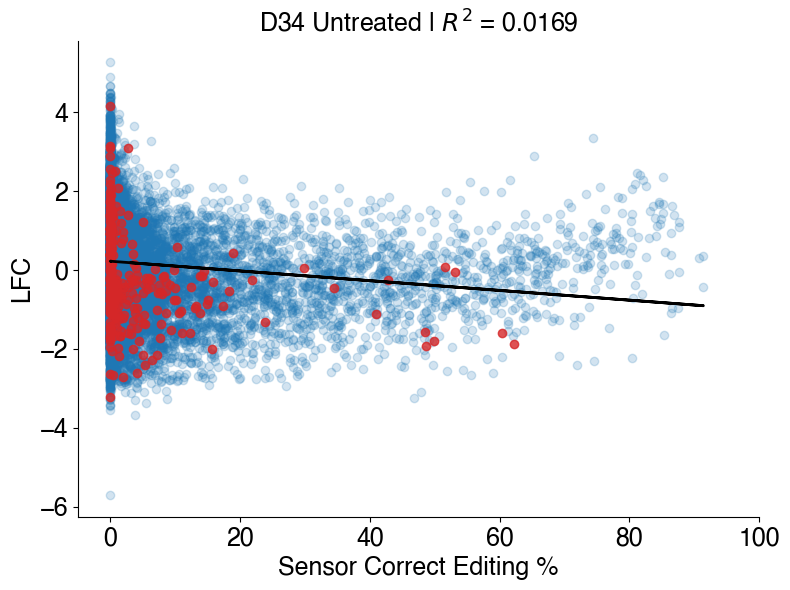

In [137]:
from sklearn.linear_model import LinearRegression

nonhot = untreated_merge_df[untreated_merge_df['hotspot']==False]
hot = untreated_merge_df[untreated_merge_df['hotspot']==True]

x = np.array(untreated_merge_df['corr_perc_D34'])
y = np.array(untreated_merge_df['LFC_D34'])

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(nonhot['corr_perc_D34'], nonhot['LFC_D34'], alpha=.2, color='tab:blue', label='non-hotspot')
ax.scatter(hot['corr_perc_D34'], hot['LFC_D34'], alpha=.8, color='tab:red', label='hotspot')


x2 = np.array(x).reshape(-1, 1)
model = LinearRegression()
model.fit(x2, y)
y_pred = model.predict(x2)
ax.plot(x2, y_pred, color='black', linewidth=2)


pear = np.round(scipy.stats.pearsonr(x,y).statistic, 3)
spear = np.round(scipy.stats.spearmanr(x,y).statistic,3)
rsq = np.round(scipy.stats.pearsonr(x,y).statistic**2, 4)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(f'D34 Untreated | R = {pear} | r = {spear}', fontsize=15)
ax.set_title(f'D34 Untreated | $R^{2}$ = {rsq}', fontsize=18)
ax.set_ylabel('LFC', fontsize=18)
ax.set_xlabel('Sensor Correct Editing %', fontsize=18)
ax.set_xlim(-5, 100)

fig.tight_layout()


In [78]:
scipy.stats.pearsonr(x,y)

PearsonRResult(statistic=-0.1298394517736852, pvalue=1.689576385470878e-63)

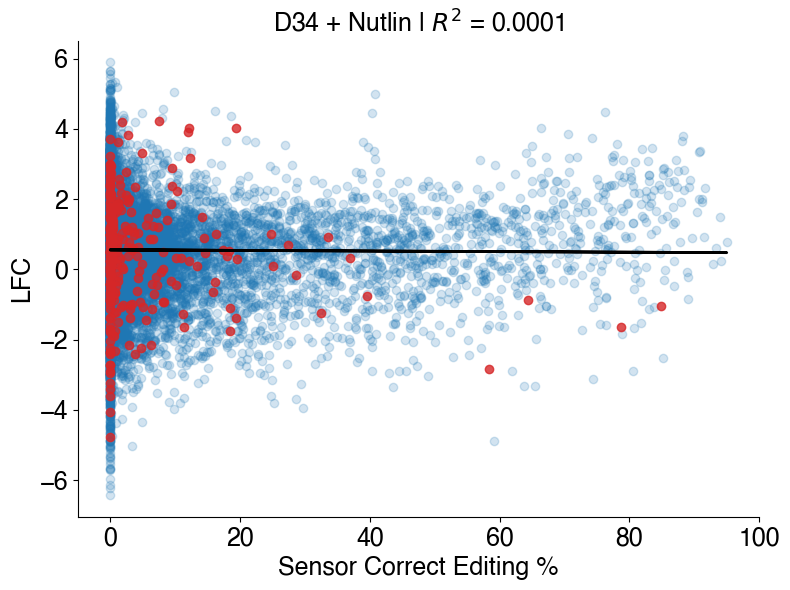

In [138]:
nonhot = nutlin_merge_df[nutlin_merge_df['hotspot']==False]
hot = nutlin_merge_df[nutlin_merge_df['hotspot']==True]

x = np.array(nutlin_merge_df['corr_perc_D34-NUT'])
y = np.array(nutlin_merge_df['LFC_D34-NUT'])

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(nonhot['corr_perc_D34-NUT'], nonhot['LFC_D34-NUT'], alpha=.2, color='tab:blue', label='non-hotspot')
ax.scatter(hot['corr_perc_D34-NUT'], hot['LFC_D34-NUT'], alpha=.8, color='tab:red', label='hotspot')


x2 = np.array(x).reshape(-1, 1)
model = LinearRegression()
model.fit(x2, y)
y_pred = model.predict(x2)
ax.plot(x2, y_pred, color='black', linewidth=2)


pear = np.round(scipy.stats.pearsonr(x,y).statistic, 3)
spear = np.round(scipy.stats.spearmanr(x,y).statistic,3)
rsq = np.round(scipy.stats.pearsonr(x,y).statistic**2, 4)


ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(f'D34 + Nutlin | R = {pear} | r = {spear}', fontsize=15)
ax.set_title(f'D34 + Nutlin | $R^{2}$ = {rsq}', fontsize=18)
ax.set_ylabel('LFC', fontsize=18)
ax.set_xlabel('Sensor Correct Editing %', fontsize=18)

ax.set_xlim(-5, 100)
fig.tight_layout()


In [145]:
hg_dict = dict(zip(p53_filtered['peg_id'], p53_filtered['HGVSp']))

nonhot['HGVSp'] = [hg_dict[i] for i in nonhot['peg_id']]
hot['HGVSp'] = [hg_dict[i] for i in hot['peg_id']]



min1=5
max1=10
#hot[(hot['corr_perc_D34-NUT']>=5) & (hot['corr_perc_D34-NUT']<=10)].sort_values(by='LFC_D34-NUT', ascending=False)
#hot[(hot['corr_perc_D34-NUT']<=10)].sort_values(by='LFC_D34-NUT', ascending=False)
mm = [0,5,10,15,20,25,30,35,40,45,50]


comb1 = []

for j in range(len(mm)-1):
    min1 = mm[j]
    max1 = mm[j+1]

    k = f'{min1} - {max1}%'

    h = hot[(hot['corr_perc_D34-NUT']>=min1) & (hot['corr_perc_D34-NUT']<=max1)].sort_values(by='LFC_D34-NUT', ascending=False)[['corr_perc_D34-NUT', 'LFC_D34-NUT', 'HGVSp', 'hotspot']]

    if len(h)>0:
        h['Editing Range'] = k
        comb1.append(h[:3])

    nh = nonhot[(nonhot['corr_perc_D34-NUT']>=min1) & (nonhot['corr_perc_D34-NUT']<=max1)].sort_values(by='LFC_D34-NUT', ascending=False)[['corr_perc_D34-NUT', 'LFC_D34-NUT', 'HGVSp', 'hotspot']]
    nh['Editing Range'] = k
    comb1.append(nh[:3])

c1 = pd.concat(comb1)

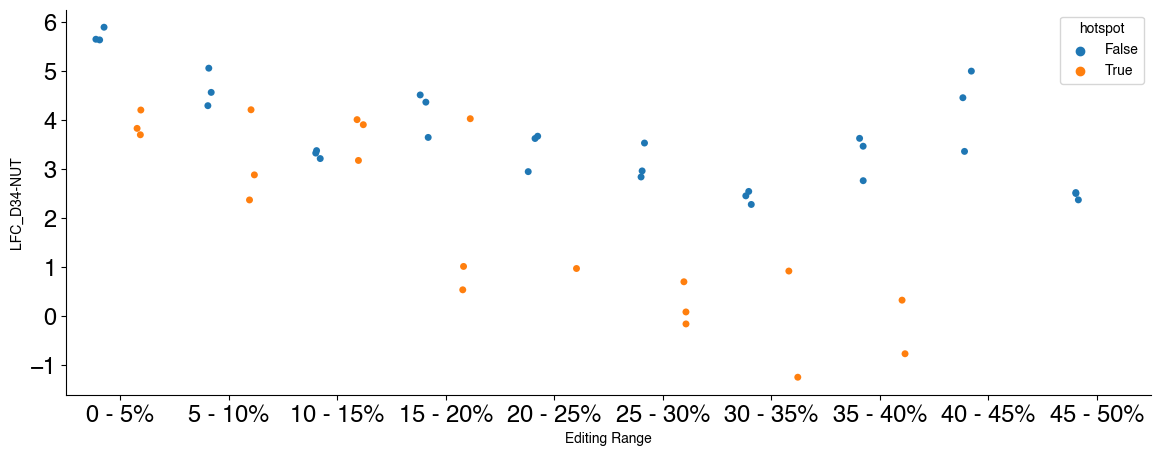

In [150]:
fig, ax = plt.subplots(figsize=(14,5))
sns.stripplot(data = c1, x='Editing Range', y='LFC_D34-NUT', hue='hotspot', dodge=True)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.spines[['right', 'top']].set_visible(False)

In [103]:
#start with D4
d4 = cp_dict2['D4'][['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']]
d4 = d4.rename(columns = {'Reads_aligned_all_amplicons':f'counts_D4', 'corr_perc':f'corr_perc_D4'})


#untreated samples
untreated = ['D16', 'D25', 'D34']
nutlin = ['D16-NUT', 'D25-NUT', 'D34-NUT']

untreated_merged = []
for sample in untreated:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    untreated_merged.append(merge1)

#nutlin samples
nutlin_merged = []
for sample in nutlin:
    a = mageck_dict[sample]
    b = cp_dict2[sample]

    merge1 = pd.merge(a[['peg_id', "LFC"]], b[['peg_id', 'Reads_aligned_all_amplicons', 'corr_perc']], on='peg_id', how='left')
    merge1 = merge1.rename(columns = {'LFC':f'LFC_{sample}', 'Reads_aligned_all_amplicons':f'counts_{sample}', 'corr_perc':f'corr_perc_{sample}'})
    nutlin_merged.append(merge1)

#untreated samples
m1 = pd.merge(d4, untreated_merged[0], on='peg_id', how='left')
m2 = pd.merge(m1, untreated_merged[1], on='peg_id', how='left')
untreated_merge_df = pd.merge(m2, untreated_merged[2], on='peg_id', how='left')

#nutlin samples
n1 = pd.merge(d4, nutlin_merged[0], on='peg_id', how='left')
n2 = pd.merge(n1, nutlin_merged[1], on='peg_id', how='left')
nutlin_merge_df = pd.merge(n2, nutlin_merged[2], on='peg_id', how='left')

#----------FILTRATION---------------
#now applying the counts and minimum editing filtration...
counts_threshold = 50
min_edit = 0 #minimum 1% editing at all timepoints

#counts thresholding
untreated_merge_df = untreated_merge_df[(untreated_merge_df['counts_D34']>=counts_threshold)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['counts_D34-NUT']>=counts_threshold)]

#filtering for only active pegRNAs...
untreated_merge_df = untreated_merge_df[(untreated_merge_df['corr_perc_D34']>=min_edit)]
nutlin_merge_df = nutlin_merge_df[(nutlin_merge_df['corr_perc_D34-NUT']>=min_edit)]

#------ANNOTATION------
#annotate the hotspots (based on the above list)

untreated_merge_df.loc[untreated_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=True
untreated_merge_df.loc[~untreated_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=False
nutlin_merge_df.loc[nutlin_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=True
nutlin_merge_df.loc[~nutlin_merge_df['peg_id'].isin(hotspot_pegs), 'hotspot']=False
nutlin_merge_df



,peg_id,counts_D4,corr_perc_D4,LFC_D16-NUT,counts_D16-NUT,corr_perc_D16-NUT,LFC_D25-NUT,counts_D25-NUT,corr_perc_D25-NUT,LFC_D34-NUT,counts_D34-NUT,corr_perc_D34-NUT,hotspot
2,peg_2,3188,1.066499,-1.22730,1786.0,11.590146,-0.051958,1960.0,14.489796,-1.08790,1455.0,18.487973,True
3,peg_3,6253,0.879578,-0.23616,3690.0,7.127371,1.446100,2970.0,11.144781,0.10645,2203.0,13.436223,True
4,peg_4,4301,0.720763,-0.87591,1945.0,0.359897,0.028506,1903.0,0.472937,-1.50950,810.0,1.234568,True
5,peg_5,9971,0.792298,-1.34900,4457.0,11.330491,-0.227230,5254.0,14.921964,-1.39250,3927.0,19.455055,True
6,peg_6,4846,0.557161,-1.07040,1900.0,9.789474,-0.107860,1967.0,12.099644,-1.75830,1013.0,18.460020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28214,peg_28669,2966,0.000000,0.97691,5660.0,0.053004,0.588620,2546.0,0.078555,1.23980,6068.0,0.098879,False
28215,peg_28670,154,0.000000,-0.63935,428.0,0.000000,-1.045200,178.0,0.000000,0.53286,1547.0,0.000000,False
28216,peg_28671,875,0.000000,1.70560,1918.0,0.364964,1.177900,725.0,0.137931,1.76490,2689.0,0.111566,False
28217,peg_28672,759,0.131752,1.38790,1888.0,0.000000,0.803540,633.0,0.000000,1.91780,2307.0,0.000000,False


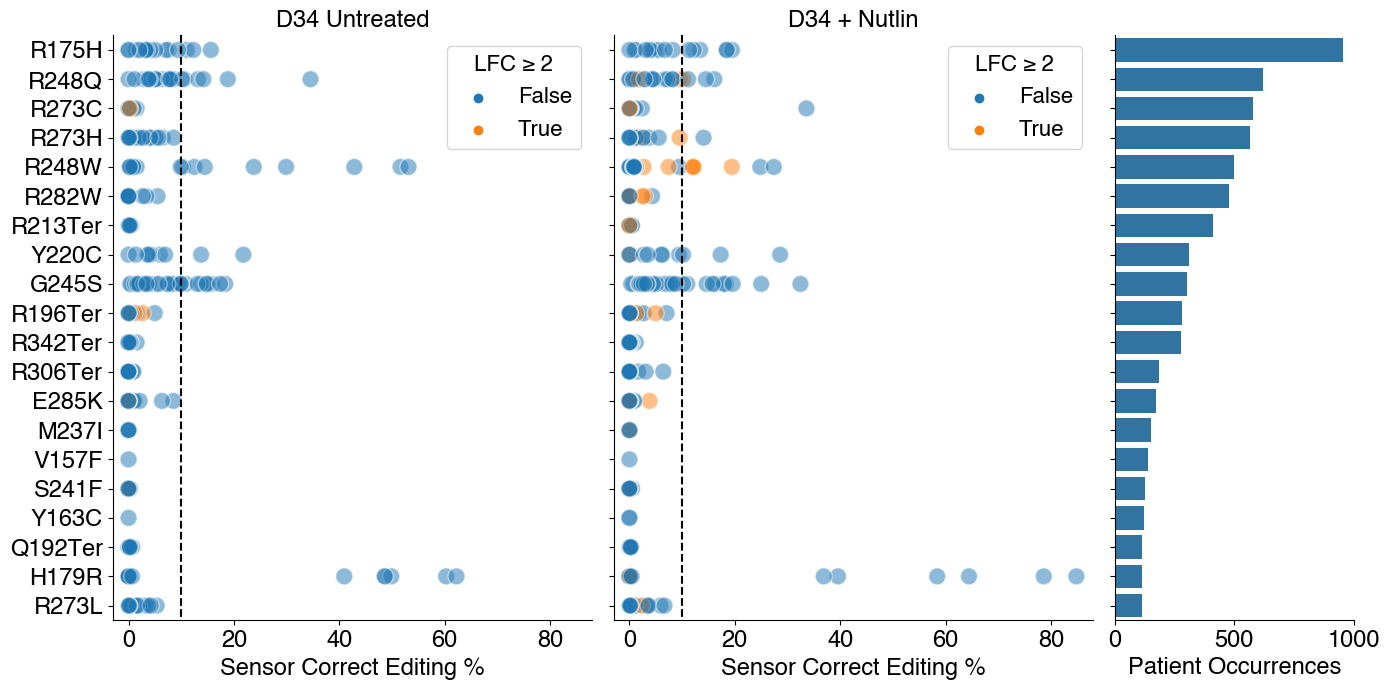

In [152]:
hot_untreat = untreated_merge_df[untreated_merge_df['hotspot']==True]
hot_nutlin = nutlin_merge_df[nutlin_merge_df['hotspot']==True]

hot_nutlin = pd.merge(hot_nutlin, p53_filtered, on='peg_id', how='left')
hot_untreat = pd.merge(hot_untreat, p53_filtered, on='peg_id', how='left')

LFC_cutoff = 2
hot_nutlin.loc[hot_nutlin['LFC_D34-NUT']>=LFC_cutoff, f'LFC ≥ {LFC_cutoff}']=True
hot_nutlin.loc[~(hot_nutlin['LFC_D34-NUT']>=LFC_cutoff), f'LFC ≥ {LFC_cutoff}']=False
hot_untreat.loc[hot_untreat['LFC_D34']>=LFC_cutoff, f'LFC ≥ {LFC_cutoff}']=True
hot_untreat.loc[~(hot_untreat['LFC_D34']>=LFC_cutoff), f'LFC ≥ {LFC_cutoff}']=False

fig, ax = plt.subplots(1, 3, figsize=(14,7), sharey=True, sharex=False, width_ratios=[1,1,.5])
sns.scatterplot(data=hot_untreat, x='corr_perc_D34', y='HGVSp', alpha=.5, s=150, hue=f'LFC ≥ {LFC_cutoff}', ax=ax[0])
sns.scatterplot(data=hot_nutlin, x='corr_perc_D34-NUT', y='HGVSp', alpha=.5, s=150, hue=f'LFC ≥ {LFC_cutoff}', ax=ax[1])


ax[0].spines[['right', 'top']].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=17)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].tick_params(axis='both', which='major', labelsize=17)
ax[0].plot([10,10],[-.5,19.5], linestyle='dashed', color='black')
ax[1].plot([10,10],[-.5,19.5], linestyle='dashed', color='black')
ax[0].set_ylim(19.5, -.5)
ax[1].set_ylim(19.5, -.5)

ax[0].legend(title = 'LFC ≥ 2', title_fontsize='16',fontsize=16)
ax[1].legend(title = 'LFC ≥ 2', title_fontsize='16',fontsize=16)

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].set_xlabel('Sensor Correct Editing %', fontsize=17)
ax[0].set_xlabel('Sensor Correct Editing %', fontsize=17)
ax[0].set_title('D34 Untreated', fontsize=17)
ax[1].set_title('D34 + Nutlin', fontsize=17)
ax[0].set_xlim(-3,88)
ax[1].set_xlim(-3,88)

sns.barplot(data=hot_nutlin, x='num_occurences', y='HGVSp', ax=ax[2], color='tab:blue')
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].tick_params(axis='both', which='major', labelsize=17)
ax[2].set_ylabel('')
ax[2].set_xlabel('Patient Occurrences', fontsize=17)
fig.tight_layout()


In [480]:
hot_nutlin

,peg_id,counts_D4,corr_perc_D4,LFC_D16-NUT,counts_D16-NUT,corr_perc_D16-NUT,LFC_D25-NUT,counts_D25-NUT,corr_perc_D25-NUT,LFC_D34-NUT,...,epegRNA_tevopreQ1_full,PBS_GC_content,distance_to_nick,homology_overhang,MIT_specificity,Doench16_Azimuth_percentile,PEGG_score,wt_qwc,edit_qwc,LFC ≥ 0.5
0,peg_2,3188,1.066499,-1.22730,1786.0,11.590146,-0.051958,1960.0,14.489796,-1.08790,...,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.600000,8,22,78,69,3.470000,5-55,5-55,False
1,peg_3,6253,0.879578,-0.23616,3690.0,7.127371,1.446100,2970.0,11.144781,0.10645,...,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.600000,8,17,78,69,3.470000,5-55,5-55,False
2,peg_4,4301,0.720763,-0.87591,1945.0,0.359897,0.028506,1903.0,0.472937,-1.50950,...,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.533333,8,22,78,69,3.470000,5-55,5-55,False
3,peg_5,9971,0.792298,-1.34900,4457.0,11.330491,-0.227230,5254.0,14.921964,-1.39250,...,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.538462,8,17,78,69,3.470000,5-55,5-55,False
4,peg_6,4846,0.557161,-1.07040,1900.0,9.789474,-0.107860,1967.0,12.099644,-1.75830,...,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.533333,8,17,78,69,3.470000,5-55,5-55,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,peg_485,1645,0.060790,0.98007,1475.0,1.152542,2.548200,632.0,2.689873,0.97129,...,AGCGTACACGTCTCACACCGACTGGGACGGAACAGCTTTGGTTTTA...,0.600000,10,5,74,53,2.070000,5-55,5-55,True
282,peg_488,840,0.357143,1.24500,1162.0,2.323580,2.678900,597.0,5.192630,1.23330,...,AGCGTACACGTCTCACACCGACTGGGACGGAACAGCTTTGGTTTTA...,0.615385,10,5,74,53,1.993077,5-55,5-55,True
283,peg_489,2571,0.077791,0.26812,2510.0,0.039841,0.379070,1886.0,0.265111,0.74864,...,AGCGTACACGTCTCACACCGCTGAGTAGTGGTAATCTACTGTTTTA...,0.400000,27,3,83,59,1.953333,5-55,5-55,True
284,peg_490,275,0.000000,-0.25652,223.0,0.000000,0.110570,161.0,0.000000,-1.58980,...,AGCGTACACGTCTCACACCGCTGAGTAGTGGTAATCTACTGTTTTA...,0.400000,27,3,83,59,1.953333,5-55,5-55,False


In [447]:
vars_only = p53_filtered.drop_duplicates(subset='HGVSp')
top20 = vars_only.sort_values(by='num_occurences', ascending=False)[0:20]
top20['HGVSp']

0        R175H
30       R248Q
54       R273C
84       R273H
114      R248W
139      R282W
163    R213Ter
175      Y220C
205      G245S
234    R196Ter
252    R342Ter
279    R306Ter
309      E285K
334      M237I
343      V157F
373      S241F
394      Y163C
406    Q192Ter
436      H179R
466      R273L
Name: HGVSp, dtype: object

# PEGG Score Analysis

In [153]:
#first read in information about the library

p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')

#and also information about the editing efficiency of each pegRNA in each time-point and replicate

samples = ['Plasmid-Library', 'D4-REP1', 'D4-REP2', 'D4-REP3',
'D16-REP1', 'D16-REP2', 'D16-REP3',
'D16-NUT-REP1', 'D16-NUT-REP2', 'D16-NUT-REP3',
'D25-REP1', 'D25-REP2', 'D25-REP3',
'D25-NUT-REP1', 'D25-NUT-REP2','D25-NUT-REP3',
'D34-REP1', 'D34-REP2', 'D34-REP3',
'D34-NUT-REP1', 'D34-NUT-REP2', 'D34-NUT-REP3']

crispresso = os.listdir("crispresso/compact_filtered_background_subtracted")

reorder = []
for i in samples:
    for k in crispresso:
        if i in k:
            df = pd.read_csv(f"crispresso/compact_filtered_background_subtracted/{k}")
            reorder.append(df)


cp_dict = dict(zip(samples, reorder))

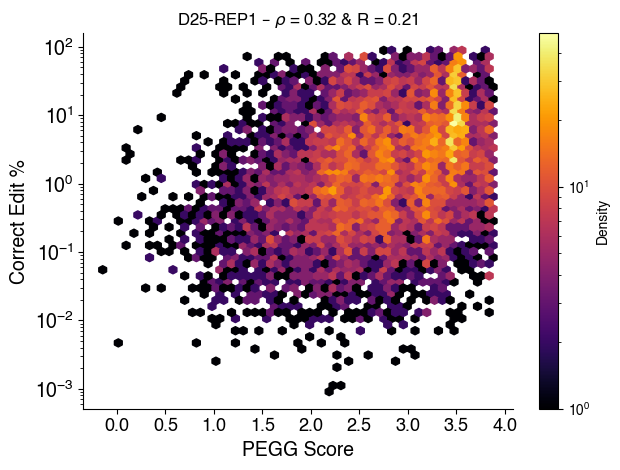

In [313]:
fig, ax1 = plt.subplots()

x='D25-REP1'

df = cp_dict[x]
counts_threshold=100

#choose a particular variant type if desired
var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

df = df[df['Reads_aligned_all_amplicons']>=counts_threshold]
#df = df[df['corr_perc_backsub']>0]


p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

x1 = np.array(p53_subset['PEGG_score'])
y1 = np.array(df['corr_perc_backsub'])

sr = scipy.stats.spearmanr(x1,y1).statistic
pr = scipy.stats.pearsonr(x1,y1).statistic


x2 = x1[y1>0]
y2 = y1[y1>0]

hb = ax1.hexbin(x2,y2, gridsize=50,  cmap='inferno', bins='log',yscale="log")

cb = fig.colorbar(hb, ax=ax1, label='Density')

ax1.set_ylabel("Correct Edit %", fontsize=14)
ax1.set_xlabel("PEGG Score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=13)
#ax1.set_xlim(0,)
#ax1.set_ylim(0,)
ax1.set_yscale("log")

ax1.set_title(x + " – "+ r"$\rho$" +  f" = {np.round(sr,2)} & R = {np.round(pr,2)}")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.tight_layout()

In [305]:
sr = scipy.stats.spearmanr(np.log10(x1+1),y1).statistic
pr = scipy.stats.pearsonr(np.log10(x1+1),np.log10(y1)).statistic
pr

0.3144496917951751

In [297]:
np.log10(x1)

array([0.54032947, 0.54032947, 0.54032947, ..., 0.40020578, 0.35346741,
       0.33840541])

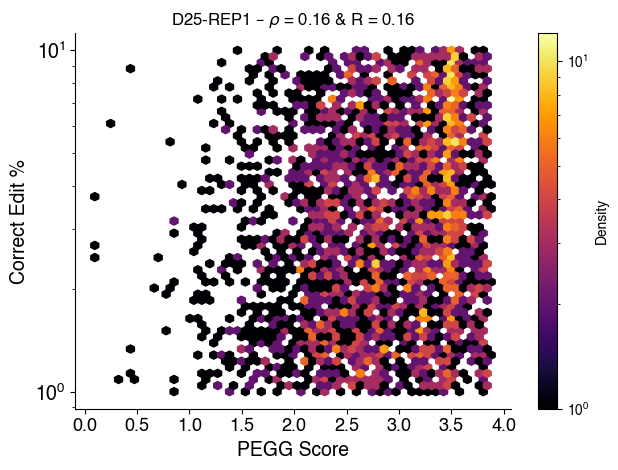

In [248]:
fig, ax1 = plt.subplots()

x='D25-REP1'

df = cp_dict[x]
counts_threshold=100

#choose a particular variant type if desired
var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

df = df[df['Reads_aligned_all_amplicons']>=counts_threshold]
df = df[(df['corr_perc_backsub']>=1) & (df['corr_perc_backsub']<=10)]


p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

x1 = np.array(p53_subset['PEGG_score'])
y1 = np.array(df['corr_perc_backsub'])

sr = scipy.stats.spearmanr(x1,y1).statistic
pr = scipy.stats.pearsonr(x1,y1).statistic


x2 = x1[y1>0]
y2 = y1[y1>0]

hb = ax1.hexbin(x2,y2, gridsize=50,  cmap='inferno', bins='log',yscale="log")

cb = fig.colorbar(hb, ax=ax1, label='Density')

ax1.set_ylabel("Correct Edit %", fontsize=14)
ax1.set_xlabel("PEGG Score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=13)
#ax1.set_xlim(0,)
#ax1.set_ylim(0,)
#ax1.set_yscale("log")

ax1.set_title(x + " – "+ r"$\rho$" +  f" = {np.round(sr,2)} & R = {np.round(pr,2)}")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.tight_layout()

In [314]:
#p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]
m1 = pd.merge(df, p53_filtered, on='peg_id')

df_0 = m1[m1['corr_perc_backsub']==0]
p_list = [np.array(df_0['PEGG_score'])]
aa = ['≤0%']

#a_list = [ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,100]
a_list = [ 0.,  5., 10.,100]

for j in range(len(a_list)-1):
    min1 = a_list[j]
    max1 = a_list[j+1]

    df_non0 = m1[(m1['corr_perc_backsub']>min1) &(m1['corr_perc_backsub']<=max1)]

    k = np.array(df_non0['PEGG_score'])
    p_list.append(k)
    aa.append(f'{int(min1)}%<x≤{int(max1)}%')


In [320]:
aa[-1] = 'x>10%'
aa

['≤0%', '0%<x≤5%', '5%<x≤10%', 'x>10%']

In [187]:
m1['PEGG_']

,peg_id,Reads_in_input,Reads_aligned_all_amplicons,WT,correct_edit,byproduct_all,byproduct_INDEL,byproduct_sub,byproduct_ambiguous,WT_perc,...,PBS_RTT_5to3,epegRNA_tevopreQ1_full,PBS_GC_content,distance_to_nick,homology_overhang,MIT_specificity,Doench16_Azimuth_percentile,PEGG_score,wt_qwc,edit_qwc
0,peg_2,987,958,842,17,99,5,92,2,87.891441,...,GCAGCGCTCATGGTGGGGGCAGTGCCTCACAACCTCCGTC,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.600000,8,22,78,69,3.470000,5-55,5-55
1,peg_3,1860,1733,1328,159,246,18,226,2,76.630121,...,GCTCATGGTGGGGGCAGTGCCTCACAACCTCCGTC,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.600000,8,17,78,69,3.470000,5-55,5-55
2,peg_4,912,910,832,25,53,8,45,0,91.428571,...,GCAGCGCTCATGGTGGGGGCAGTGCCTCACAACCTCCGTCATGTG,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.533333,8,22,78,69,3.470000,5-55,5-55
3,peg_5,2257,2254,1694,163,397,93,303,1,75.155280,...,GCTCATGGTGGGGGCAGTGCCTCACAACCTCCGTCATG,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.538462,8,17,78,69,3.470000,5-55,5-55
4,peg_6,799,798,685,70,43,3,40,0,85.839599,...,GCTCATGGTGGGGGCAGTGCCTCACAACCTCCGTCATGTG,AGCGTACACGTCTCACACCGAGCACATGACGGAGGTTGTGGTTTTA...,0.533333,8,17,78,69,3.470000,5-55,5-55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,peg_28669,6245,6199,5791,2,406,9,397,0,93.418293,...,TGAGTCTGGCCCTTCTGTCTTGAACATG,AGCGTACACGTCTCACACCGAACTCATGTTCAAGACAGAAGTTTTA...,0.384615,7,6,55,84,2.513077,5-55,5-55
13720,peg_28670,1523,1478,1270,0,208,32,175,1,85.926928,...,ACAGAAGGGCCAGACTCAGACTGACATT,AGCGTACACGTCTCACACCGGGAGAATGTCAGTCTGAGTCGTTTTA...,0.384615,4,11,69,43,2.509744,5-55,5-55
13721,peg_28671,3164,3147,2885,0,262,21,241,0,91.674611,...,CAGTCTGAGTCTGGCCCTTCTGTCTTGAAC,AGCGTACACGTCTCACACCGAACTCATGTTCAAGACAGAAGTTTTA...,0.400000,7,11,55,84,2.256667,5-55,5-55
13722,peg_28672,3127,3122,2811,4,307,57,249,1,90.038437,...,CAGTCTGAGTCTGGCCCTTCTGTCTTGAACATGAG,AGCGTACACGTCTCACACCGAACTCATGTTCAAGACAGAAGTTTTA...,0.400000,7,11,55,84,2.256667,5-55,5-55


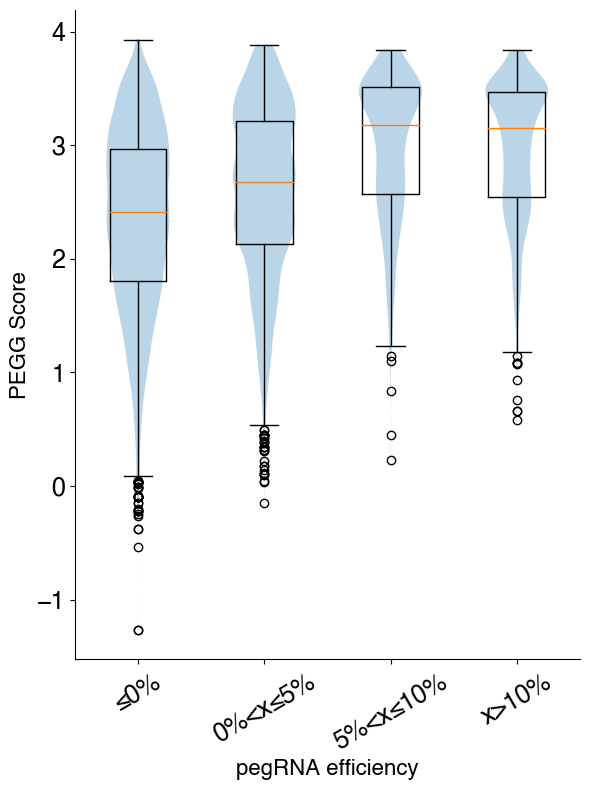

In [321]:
fig, ax = plt.subplots(figsize=(6,8))
ax.violinplot(p_list, showextrema=False);
ax.boxplot(p_list);
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticklabels(aa, rotation=30)
ax.set_ylabel('PEGG Score', fontsize=16)
ax.set_xlabel('pegRNA efficiency', fontsize=16)
fig.tight_layout()

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06274008, 0.08365344, 0.04182672, 0.20913359, 0.12548015,
        0.08365344, 0.27187367, 0.14639351, 0.41826718, 0.39735382,
        0.66922749, 0.31370038, 0.43918054, 0.23004695, 0.33461374,
        0.48100726, 0.41826718, 0.62740077, 0.27187367, 2.09133589,
        0.43918054, 0.4600939 , 0.29278703, 0.        ]),
 array([-1.5       , -1.3877551 , -1.2755102 , -1.16326531, -1.05102041,
        -0.93877551, -0.82653061, -0.71428571, -0.60204082, -0.48979592,
        -0.37755102, -0.26530612, -0.15306122, -0.04081633,  0.07142857,
         0.18367347,  0.29591837,  0.40816327,  0.52040816,  0.63265306,
         0.74489796,  0.85714286,  0.9

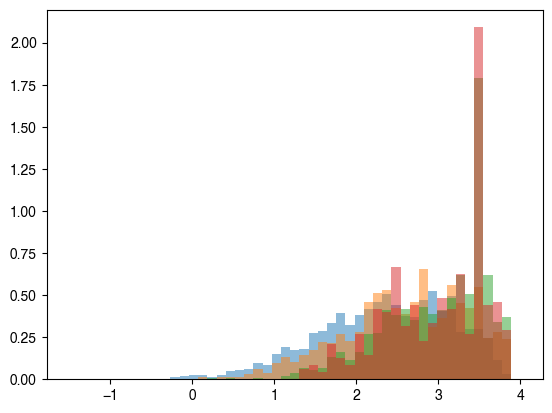

In [240]:
plt.hist(p_list[0], bins = np.linspace(-1.5, 4, 50), alpha=.5, density=True)
plt.hist(p_list[1], bins = np.linspace(-1.5, 4, 50), alpha=.5, density=True)
plt.hist(p_list[2], bins = np.linspace(-1.5, 4, 50), alpha=.5, density=True)
plt.hist(p_list[3], bins = np.linspace(-1.5, 4, 50), alpha=.5, density=True)

In [249]:
x = 'D16-REP1'
df = cp_dict[x] #see code above (Figure 2a for cp_dict assignment)

counts_threshold=100

#choose a particular variant type if desired
var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

df = df[df['Reads_aligned_all_amplicons']>=counts_threshold]

p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

#would be easier to just merge these dataframes (functionally the same when indexing is identical like this though)
assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

b = p53_subset

In [250]:
#training of the model
from sklearn.ensemble import RandomForestRegressor # for building the model

def model_training():
    #converting PAM sequences and variant types to integers for training
    PAM_dict = {"AGG":0, 'GGG':1, 'CGG':2, 'TGG':3}
    num_PAM = [PAM_dict[k] for k in b['PAM']]
    b['num_PAM'] = num_PAM

    var_dict = {"SNV":0, 'INS':1, 'DEL':2, 'ONV':3}
    num_var = [var_dict[k] for k in b['variant_type']]
    b['var_type'] = num_var

    #adding in correct percentage
    b['corr_perc'] = df['corr_perc_backsub']

    #train, test splitting; ensuring same variant isn't in train and test
    uniq_DNA = np.unique(b['HGVSc'])
    perc_train = .7
    num_train = int(perc_train*len(uniq_DNA))

    train_set = list(np.random.choice(uniq_DNA, size=num_train, replace=False))

    train = b[b['HGVSc'].isin(train_set)]
    test =b[~b['HGVSc'].isin(train_set)]

    X_train = np.array(train[["PBS_length", "Doench16_Azimuth_percentile", "PBS_GC_content", "homology_overhang","distance_to_nick", "RTT_length", "num_PAM", "var_type"]])
    Y_train = np.array(train[["corr_perc"]])

    X_test = np.array(test[["PBS_length", "Doench16_Azimuth_percentile", "PBS_GC_content", "homology_overhang","distance_to_nick", "RTT_length", "num_PAM", "var_type"]])
    Y_test = np.array(test[["corr_perc"]])


    # Initializing the Random Forest Regression model with 10 decision trees
    model = RandomForestRegressor(n_estimators = 1000, random_state = 0)

    # Fitting the Random Forest Regression model to the data
    model.fit(X_train, Y_train)

    return model, X_test, Y_test, test, train

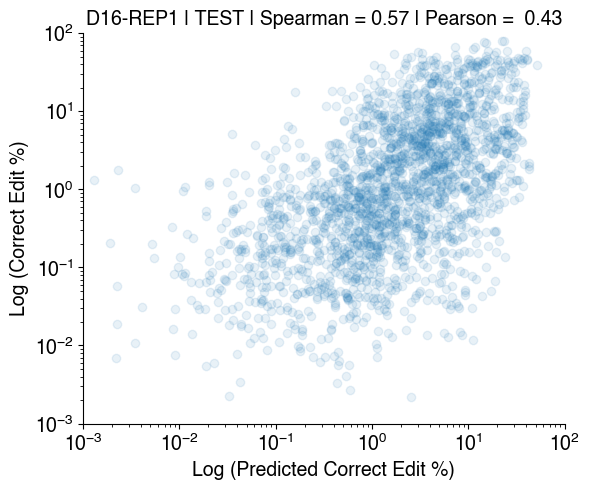

In [257]:
#note: precise values of spearman correlation will vary based on training run
#models can be saved for use with pickle model
model, X_test, Y_test, test, train = model_training()

y_pred = model.predict(X_test)


#----and plotting-------

fig, ax = plt.subplots(figsize=(6,5))
plt.scatter(y_pred, Y_test,alpha=.1)
plt.yscale("log")
plt.xscale("log")
plt.ylim(.001,100)
plt.xlim(.001,100)

plt.ylabel("Log (Correct Edit %)", fontsize=14)
plt.xlabel("Log (Predicted Correct Edit %)", fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

jj = scipy.stats.spearmanr(y_pred, Y_test)
j2 = jj.statistic

jj2 = scipy.stats.pearsonr(y_pred, Y_test)
j3 = jj2.statistic

ax.set_title(f'{x} | TEST | Spearman = {np.round(j2, 2)} | Pearson =  {np.round(j3[0], 2)}', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

PearsonRResult(statistic=array([nan], dtype=object), pvalue=nan)

In [311]:
min(np.log10(y_pred))

-inf

Text(0, 0.5, 'RF Score')

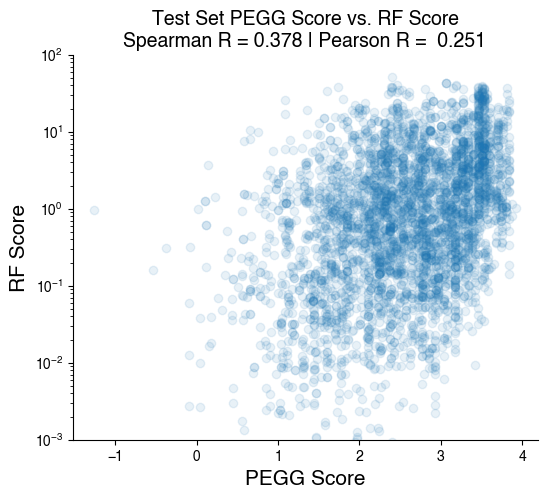

In [330]:
spear = np.round(scipy.stats.spearmanr(test['PEGG_score'], y_pred).statistic, 3)
pear = np.round(scipy.stats.pearsonr(test['PEGG_score'], y_pred).statistic,3)

fig, ax = plt.subplots(figsize=(6,5))
x = test['PEGG_score']
y = y_pred
ax.scatter(x,y, alpha=.1)

ax.set_title(f'Test Set PEGG Score vs. RF Score\nSpearman R = {spear} | Pearson R =  {pear}', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yscale("log")
#plt.xscale("log")
plt.ylim(.001,100)
ax.set_xlabel('PEGG Score', fontsize=15)
ax.set_ylabel('RF Score', fontsize=15)

In [333]:
aaa = y[y>0]
bbb = x[y>0]+2

scipy.stats.pearsonr(np.log10(aaa), np.log10(bbb))

PearsonRResult(statistic=0.37619159231629284, pvalue=2.9511594910275446e-131)

In [331]:
x[y>0]

2        3.470000
3        3.470000
4        3.470000
5        3.470000
6        3.470000
           ...   
28214    2.513077
28215    2.509744
28216    2.256667
28217    2.256667
28218    2.179744
Name: PEGG_score, Length: 3897, dtype: float64

In [329]:
x

'D25-REP1'

In [324]:
len(y)

3902

# BE comparison

Target cytosine editing (tCTN, tCGN, tCAN) quantified the frequency of editing at the target cytosine regardless of editing at other adjacent cytosines. Target cytosine editing without collateral editing (tCT) was measured as specific C > T editing without associated mutations at adjacent sites.

In [360]:
homologs = pd.read_csv('/Users/samgould/Desktop/Kexin/h2m examples/example_1003_TP53_all.csv')
convert_dict = dict(zip(homologs['protein_change_m'], homologs['protein_change_h']))


In [380]:
mbes = pd.read_csv('/Users/samgould/Desktop/MBES_mageck.csv')
mbes = mbes[:4261]

#mutations already in human format
mbes = mbes[mbes['Symbol']=='Trp53']


mbes['Mutation'] = [i.replace('*', 'Ter') for i in mbes['Mutation']]

mbes = mbes.rename(columns={'Mutation':'HGVSp'})

In [381]:
np.unique(mbes['HGVSp'])

array(['A138V', 'A159V', 'A161T', 'C135Y', 'C141Y', 'C238Y', 'C242Y',
       'C275Y', 'D281N', 'E258K', 'E271K', 'E286K', 'E287K', 'G105D',
       'G199E', 'G245D', 'G245S', 'G279E', 'H179Y', 'H193Y', 'L194F',
       'M237I', 'M246I', 'P151S', 'P152L', 'P278L', 'P27S', 'Q100Ter',
       'Q104Ter', 'Q136Ter', 'Q144Ter', 'Q167Ter', 'Q192Ter', 'Q375Ter',
       'R110C', 'R158H', 'R181C', 'R181H', 'R196Ter', 'R213Q', 'R213Ter',
       'R248Q', 'R267W', 'R273C', 'R273H', 'R282W', 'R337C', 'R337H',
       'R342Ter', 'S241F', 'T211I', 'V143M', 'V197M', 'V216M', 'V272M',
       'W146Ter', 'W91Ter'], dtype=object)

In [403]:
m2 = mbes[['HGVSp','guide_ID', 'mean_tCT', 'mean_tCTN', 'LFC', 'FDR']]
m2 = m2.rename(columns = {'LFC':'LFC_base', 'FDR':'FDR_base'})
m2

,HGVSp,guide_ID,mean_tCT,mean_tCTN,LFC_base,FDR_base
61,E258K,Trp53_E258K_4450,0.005193,50.538439,6.23860,0.000000e+00
66,Q100Ter,Trp53_Q100*_4514,0.586803,77.946765,6.03330,0.000000e+00
107,D281N,Trp53_D281N_4425,0.091364,27.095754,5.87300,0.000000e+00
141,M237I,Trp53_M237I_4350,0.414605,47.217367,5.66180,0.000000e+00
293,W91Ter,Trp53_W91*_4421,0.003921,81.444993,4.91020,0.000000e+00
...,...,...,...,...,...,...
4133,W146Ter,Trp53_W146*_4392,0.075415,6.557768,-0.23492,3.595600e-01
4134,W91Ter,Trp53_W91*_4419,0.000000,0.000000,0.32821,1.630300e-01
4135,W91Ter,Trp53_W91*_4424,0.000000,7.515037,-0.34682,3.447400e-01
4138,W91Ter,Trp53_W91*_4422,0.000000,0.275016,0.87066,6.000000e-07


In [401]:
mbes

,Symbol,HGVSp,guide_ID,total_REP1,percent_tCTN_REP1,percent_tCT_REP1,total_REP2,percent_tCTN_REP2,percent_tCT_REP2,total_REP3,...,score,p.low,p.high,p.twosided,FDR,high_in_treatment,p53_status,Hs_symbol,MUTATION_EFFECT,ONCOGENIC
61,Trp53,E258K,Trp53_E258K_4450,20315.0,78.592170,0.004922,2983.0,69.326180,0.000000,8313.0,...,580.07000,1.00000,0.000000e+00,0.000000e+00,0.000000e+00,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
66,Trp53,Q100Ter,Trp53_Q100*_4514,9890.0,75.591510,0.303337,14456.0,89.872720,1.902324,13938.0,...,505.39000,1.00000,0.000000e+00,0.000000e+00,0.000000e+00,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
107,Trp53,D281N,Trp53_D281N_4425,9027.0,32.225544,0.177246,6936.0,8.217993,0.028835,2417.0,...,345.78000,1.00000,0.000000e+00,0.000000e+00,0.000000e+00,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
141,Trp53,M237I,Trp53_M237I_4350,5942.0,49.461460,2.187816,11471.0,37.189434,0.008718,15318.0,...,431.21000,1.00000,0.000000e+00,0.000000e+00,0.000000e+00,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
293,Trp53,W91Ter,Trp53_W91*_4421,1639.0,81.269066,0.000000,8026.0,80.239220,0.000000,3012.0,...,164.87000,1.00000,0.000000e+00,0.000000e+00,0.000000e+00,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,Trp53,W146Ter,Trp53_W146*_4392,221.0,1.809955,0.452489,178.0,5.056180,0.000000,152.0,...,1.16090,0.12283,8.771700e-01,2.456700e-01,3.595600e-01,False,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
4134,Trp53,W91Ter,Trp53_W91*_4419,187.0,0.000000,0.000000,161.0,0.000000,0.000000,159.0,...,1.70130,0.95555,4.444700e-02,8.889400e-02,1.630300e-01,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
4135,Trp53,W91Ter,Trp53_W91*_4424,72.0,0.000000,0.000000,144.0,1.388889,0.000000,69.0,...,1.19600,0.11586,8.841400e-01,2.317100e-01,3.447400e-01,False,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic
4138,Trp53,W91Ter,Trp53_W91*_4422,136.0,1.470588,0.000000,7242.0,0.179508,0.000000,249.0,...,5.41070,1.00000,3.140000e-08,6.280000e-08,6.000000e-07,True,Trp53,TP53,Likely Loss-of-function,Likely Oncogenic


In [383]:
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [483]:
sample = 'D34'
counts_threshold=10 #minimum number of sensor reads for inclusion
corr_perc_max = 100
corr_perc_min=0

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])
bb['FDR_below_.05'] = bb['FDR']<.05

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
#p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

bb = pd.merge(bb, d34, on='peg_id')

bb2 = bb[(bb['corr_perc_backsub']>=corr_perc_min) & (bb['corr_perc_backsub']<=corr_perc_max)]
bb2

,peg_id,variant_index,HGVSp,HGVSc,gene,chr,start,end,variant_type,classification,...,byproduct_sub,byproduct_ambiguous,WT_perc,corr_perc,byprod_perc,INDEL_perc,corr_perc_backsub,byprod_perc_backsub,INDEL_perc_backsub,WT_perc_backsub
0,peg_1,0.00001,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,0,21,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,100.000000
1,peg_2,0.00001,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,278,3,82.605145,3.225806,14.169049,2.694978,3.044975,5.850785,1.248323,91.104241
2,peg_3,0.00001,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,359,5,73.254760,11.060743,15.684497,7.434270,10.982435,4.564685,5.085014,84.452880
3,peg_4,0.00001,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,155,2,86.613692,1.405868,11.980440,2.383863,1.405868,0.000000,0.080600,98.594132
4,peg_5,0.00001,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,Observed SNV,...,1007,2,67.519522,12.311015,20.169463,3.405881,12.311015,6.932648,0.200090,80.756336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19554,peg_28669,1281.00000,P390P,c.1170T>A,TP53,chr17,7572939,7572941,SNV,Silent,...,830,11,93.906713,0.121327,5.971960,0.303316,0.121327,0.000000,0.000000,99.878673
19555,peg_28670,1281.00000,P390P,c.1170T>A,TP53,chr17,7572939,7572941,SNV,Silent,...,297,7,85.753106,0.000000,14.246894,2.445652,0.000000,5.232219,1.502256,94.767781
19556,peg_28671,1281.00000,P390P,c.1170T>A,TP53,chr17,7572939,7572941,SNV,Silent,...,437,0,89.363723,0.000000,10.636277,3.719531,0.000000,2.377418,2.979932,97.622582
19557,peg_28672,1281.00000,P390P,c.1170T>A,TP53,chr17,7572939,7572941,SNV,Silent,...,475,1,90.383376,0.032216,9.584407,1.916881,0.000000,0.869107,0.238379,99.130893


In [484]:
base_prime = pd.merge(m2, bb2, on='HGVSp')

prime_min = 5
base_min = 5

filtered = base_prime[(base_prime['corr_perc_backsub']>=prime_min) & (base_prime['mean_tCT']>=base_min)]

In [504]:
all = len(np.unique(base_prime['HGVSp']))

prime1 = len(np.unique(base_prime[(base_prime['corr_perc_backsub']>=prime_min)]['HGVSp']))
base1 = len(np.unique(base_prime[(base_prime['mean_tCT']>=base_min)]['HGVSp']))

filtered = base_prime[(base_prime['corr_perc_backsub']>=prime_min) & (base_prime['mean_tCT']>=base_min)]
both = len(np.unique(filtered['HGVSp']))

print(all, prime1-both, base1-both, both)

57 13 13 4


In [565]:
np.unique(filtered['HGVSp'])

array(['C275Y', 'E258K', 'E271K', 'M246I'], dtype=object)

In [502]:
p1 = np.unique(base_prime[(base_prime['corr_perc_backsub']>=prime_min)]['HGVSp'])
b1 = np.unique(base_prime[(base_prime['mean_tCT']>=base_min)]['HGVSp'])
[i for i in p1 if i in b1]

['C275Y', 'E258K', 'E271K', 'M246I']

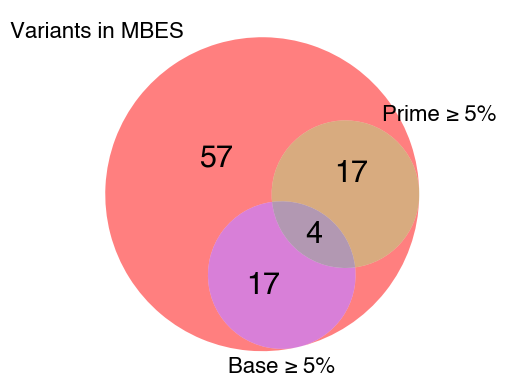

<Figure size 640x480 with 0 Axes>

In [581]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 

# Make the diagram
out = venn3(subsets = (all, 0, prime1, 0,base1,0,both), set_labels = ('Variants in MBES', f'Prime ≥ {prime_min}%', f'Base ≥ {base_min}%'), alpha = 0.5);
for text in out.set_labels:
    text.set_fontsize(16)
for text in out.subset_labels:
    print
    if text!=None:
        text.set_fontsize(22)
plt.show()
plt.tight_layout()

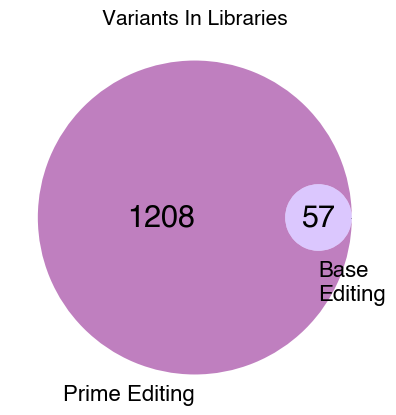

<Figure size 640x480 with 0 Axes>

In [562]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 
prime2 = len(np.unique(p53_filtered['HGVSp']))
base_size = len(np.unique(m2['HGVSp']))
# Make the diagram
out = venn2(subsets = (prime2, 0, base_size), set_labels = ('Prime Editing', 'Base\nEditing'), set_colors=('purple', 'skyblue'),alpha=.5)

for text in out.set_labels:
    text.set_fontsize(16)
for i, text in enumerate(out.subset_labels):
    print
    if i!=1:
        text.set_fontsize(22)
    if i==1:
        text.set_fontsize(0)

plt.title('Variants In Libraries', fontsize=15)
plt.show()
plt.tight_layout()


In [571]:
np.unique(filtered['HGVSp'])

array(['C275Y', 'E258K', 'E271K', 'M246I'], dtype=object)

In [573]:

prime_min = 5
base_min = 5

shared = list(np.unique(filtered['HGVSp']))
m3 = m2[m2['mean_tCT']>=base_min]
m3 = m3[m3['HGVSp'].isin(shared)]

m3 = m3.rename(columns = {'LFC_base':'LFC'})
m3['System'] = 'Base'
m3

,HGVSp,guide_ID,mean_tCT,mean_tCTN,LFC,FDR_base,System
3950,C275Y,Trp53_C275Y_4397,17.007942,18.762710,-0.32485,2.272100e-01,Base
3954,E258K,Trp53_E258K_4454,13.104065,55.207719,0.78586,8.010000e-11,Base
3960,E271K,Trp53_E271K_4478,33.575682,42.544749,0.17098,5.459000e-01,Base
3996,M246I,Trp53_M246I_4522,6.279223,6.484984,0.20074,6.028500e-01,Base


In [577]:
p3 = bb2[bb2['corr_perc_backsub']>=prime_min]
p3 = p3[p3['HGVSp'].isin(shared)]
p3['System']= 'Prime'

concated = pd.concat((m3, p3))
concated

,HGVSp,guide_ID,mean_tCT,mean_tCTN,LFC,FDR_base,System,peg_id,variant_index,HGVSc,...,byproduct_sub,byproduct_ambiguous,WT_perc,corr_perc,byprod_perc,INDEL_perc,corr_perc_backsub,byprod_perc_backsub,INDEL_perc_backsub,WT_perc_backsub
3950,C275Y,Trp53_C275Y_4397,17.007942,18.762710,-0.324850,2.272100e-01,Base,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3954,E258K,Trp53_E258K_4454,13.104065,55.207719,0.785860,8.010000e-11,Base,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3960,E271K,Trp53_E271K_4478,33.575682,42.544749,0.170980,5.459000e-01,Base,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,M246I,Trp53_M246I_4522,6.279223,6.484984,0.200740,6.028500e-01,Base,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,C275Y,NaN,NaN,NaN,-2.186500,NaN,Prime,peg_1355,57.0,c.824G>A,...,295.0,1.0,67.397882,6.127080,26.475038,4.084720,6.127080,16.789503,1.317425,77.083417
902,C275Y,NaN,NaN,NaN,-1.485200,NaN,Prime,peg_1371,57.0,c.824G>A,...,305.0,7.0,68.120805,5.760626,26.118568,8.668904,5.547860,12.288781,5.158266,82.163359
1164,E258K,NaN,NaN,NaN,-1.745000,NaN,Prime,peg_1731,73.0,c.772G>A,...,114.0,0.0,73.221757,12.343096,14.435146,2.510460,12.343096,3.801662,0.000000,83.855241
1165,E258K,NaN,NaN,NaN,-0.734710,NaN,Prime,peg_1732,73.0,c.772G>A,...,7480.0,258.0,51.777541,10.314126,37.908333,13.649759,10.100177,26.312269,11.125154,63.587554
1167,E258K,NaN,NaN,NaN,-0.553270,NaN,Prime,peg_1734,73.0,c.772G>A,...,4382.0,47.0,54.692122,14.555884,30.751994,10.903469,14.360826,19.308561,8.107630,66.330613
1168,E258K,NaN,NaN,NaN,-2.373200,NaN,Prime,peg_1735,73.0,c.772G>A,...,108.0,2.0,77.631579,5.263158,17.105263,3.947368,5.263158,10.496068,2.654265,84.240774


<AxesSubplot: xlabel='HGVSp', ylabel='LFC'>

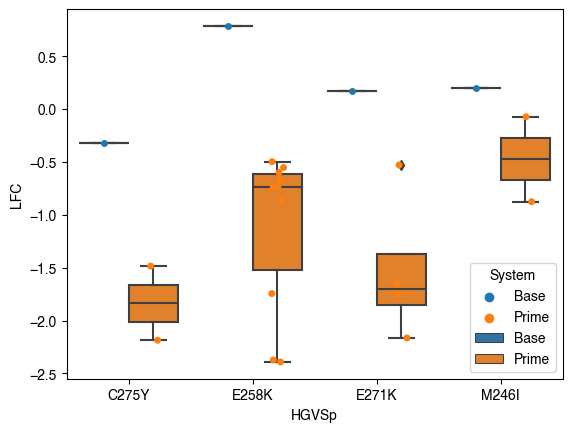

In [579]:
sns.stripplot(data=concated, x='HGVSp',y='LFC', hue='System', dodge=True)
sns.boxplot(data=concated, x='HGVSp',y='LFC', hue='System')

In [580]:
shared

['C275Y', 'E258K', 'E271K', 'M246I']

In [486]:
np.unique(base_prime[(base_prime['mean_tCT']>=base_min)]['HGVSp'])

array(['C135Y', 'C275Y', 'E258K', 'E271K', 'E287K', 'G199E', 'H179Y',
       'L194F', 'M237I', 'M246I', 'R158H', 'R213Ter', 'R273C', 'R337C',
       'S241F', 'V216M', 'W91Ter'], dtype=object)

In [556]:
base_prime = pd.merge(m2, bb2, on='HGVSp')

prime_min = 5
base_min = 5

filtered = base_prime[(base_prime['corr_perc_backsub']>=prime_min) & (base_prime['mean_tCT']>=base_min)]

Text(0, 0.5, 'Base Editing LFC')

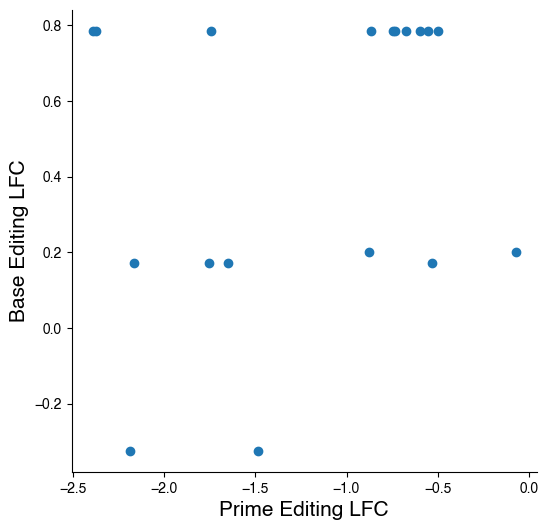

In [557]:
fig, ax= plt.subplots(figsize=(6,6))
ax.scatter(filtered['LFC'], filtered['LFC_base'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.xscale("log")
ax.set_xlabel('Prime Editing LFC', fontsize=15)
ax.set_ylabel('Base Editing LFC', fontsize=15)

In [558]:
scipy.stats.spearmanr(filtered['LFC'], filtered['LFC_base'])

SignificanceResult(statistic=0.23286578812506326, pvalue=0.3524167364846901)

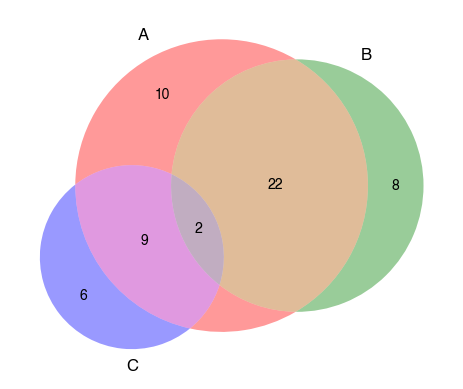

In [490]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
# Make the diagram
venn3(subsets = (10, 8, 22, 6,9,0,2))
plt.show()